<a href="https://colab.research.google.com/github/YoonSungLee/Galaxies-Classification-By-Using-Deep-Learning/blob/master/Pratice_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브 mount

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# 패키지 불러오기

import numpy as np
from keras import Input
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16

Using TensorFlow backend.


In [3]:
# 랜덤시드 고정
np.random.seed(3)

# 데이터 생성
# rescale: rescaling factor. Defaults to None.
# If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (before applying any other transformation).
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/train_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/val_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/datasets/test_galaxy', # 파일 경로
    target_size=(224,224), # 이미지의 크기
    batch_size=16,# 배치 크기
    class_mode='categorical'# 분류 방식
)

Found 10249 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# VGG16_Model 1

* pre-trained network
* weight='imagenet'
* vgg16_model1.trainable = False
* Dense 4096, 2048, 1024, 3

In [0]:
# weights='imagenet' : 이미지넷으로 트레이닝된 모델을 불러온다
# include_top : 상단의 F.C layer를 포함할 것인지 아닌지 결정하는 파라미터
# VGG16.trainable = True/False : feature extraction 파라미터 학습여부

# VGGNet = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
VGGNet = VGG16(weights='imagenet')
VGGNet.trainable = False

VGGNet.summary()

553467904/553467096 [==============================] - 41s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [0]:
vgg_maxpool5 = VGGNet.get_layer('block5_pool').output

Feature_Flatten = Flatten()(vgg_maxpool5)
dense1 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense1')(Feature_Flatten)
dense2 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense2')(dense1)
dense3 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense3')(dense2)
predictions = Dense(3, activation='softmax', name='output')(dense3)

VGG16_Model1 = Model(inputs=VGGNet.input, outputs=predictions)

VGG16_Model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

VGG16_Model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
# 학습 조기종료

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# 최적 모델 선택 기법

filepath = '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/best_VGG16_model1-{epoch:02d}-{val_acc:.2f}.h5'
mc = ModelCheckpoint(filepath,
                     monitor='val_loss',
                     mode='min',
                     save_best_only=True)

In [0]:
# 모델 학습시키기

hist = VGG16_Model1.fit_generator(
    train_generator,
    steps_per_epoch=640,
    epochs=100,
    validation_data=val_generator,
    validation_steps=30,
    callbacks=[es,mc]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
640/640 [==============================] - 5612s 9s/step - loss: 8.8597 - acc: 0.4497 - val_loss: 10.9805 - val_acc: 0.3187
Epoch 2/100
640/640 [==============================] - 270s 422ms/step - loss: 8.8837 - acc: 0.4488 - val_loss: 10.5177 - val_acc: 0.3475
Epoch 3/100
640/640 [==============================] - 270s 421ms/step - loss: 8.8824 - acc: 0.4489 - val_loss: 10.5177 - val_acc: 0.3475
Epoch 4/100
640/640 [==============================] - 269s 421ms/step - loss: 8.8837 - acc: 0.4488 - val_loss: 10.7226 - val_acc: 0.3347
Epoch 5/100
640/640 [==============================] - 270s 421ms/step - loss: 8.8789 - acc: 0.4491 - val_loss: 10.9469 - val_acc: 0.3208
Epoch 6/100
640/640 [==============================] - 269s 421ms/step - loss: 8.8786 - acc: 0.4492 - val_loss: 10.8934 - val_acc: 0.3242
Epoch 7/100
640/640 [==============================] - 269s 421ms/step - loss:

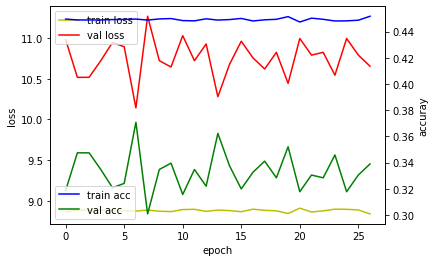

In [0]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# VGG16_Model 2

* pre-trained network
* weight='imagenet'
* vgg16_model1.trainable = True
* Dense 4096, 2048, 1024, 3

In [0]:
VGGNet = VGG16(weights='imagenet')
VGGNet.trainable = False

VGGNet.summary()





553467904/553467096 [==============================] - 12s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________

In [0]:
vgg_maxpool5 = VGGNet.get_layer('block5_pool').output

Feature_Flatten = Flatten()(vgg_maxpool5)
dense1 = Dense(4096, activation='relu', kernel_initializer='he_normal', name='dense1')(Feature_Flatten)
dense2 = Dense(2048, activation='relu', kernel_initializer='he_normal', name='dense2')(dense1)
dense3 = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense3')(dense2)
predictions = Dense(3, activation='softmax', name='output')(dense3)

VGG16_Model2 = Model(inputs=VGGNet.input, outputs=predictions)

VGG16_Model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

VGG16_Model2.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0

In [0]:
# 학습 조기종료

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [0]:
# 최적 모델 선택 기법

filepath = '/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing/best_VGG16_model2-{epoch:02d}-{val_acc:.2f}.h5'
mc = ModelCheckpoint(filepath,
                     monitor='val_loss',
                     mode='min',
                     save_best_only=True)

In [0]:
# 모델 학습시키기

hist = VGG16_Model2.fit_generator(
    train_generator,
    steps_per_epoch=640,
    epochs=100,
    validation_data=val_generator,
    validation_steps=30,
    callbacks=[es,mc]
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
640/640 [==============================] - 3284s 5s/step - loss: 8.8684 - acc: 0.4489 - val_loss: 10.9805 - val_acc: 0.3187
Epoch 2/100
640/640 [==============================] - 269s 421ms/step - loss: 8.8824 - acc: 0.4489 - val_loss: 10.5519 - val_acc: 0.3453
Epoch 3/100
640/640 [==============================] - 270s 421ms/step - loss: 8.8777 - acc: 0.4492 - val_loss: 10.4836 - val_acc: 0.3496
Epoch 4/100
640/640 [==============================] - 270s 422ms/step - loss: 8.8774 - acc: 0.4492 - val_loss: 10.7226 - val_acc: 0.3347
Epoch 5/100
640/640 [==============================] - 270s 422ms/step - loss: 8.8789 - acc: 0.4491 - val_loss: 10.9469 - val_acc: 0.3208
Epoch 6/100
640/640 [==============================] - 270s 422ms/step - loss: 8.8896 - acc: 0.4485 - val_loss: 10.8934 - val_acc: 0.3242
Epoch 7/100
640/640 [==============================] - 270s 422ms/step - loss:

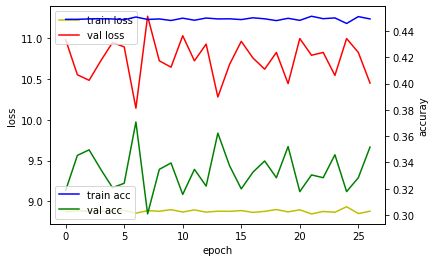

In [0]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [4]:
cd gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing

/content/gdrive/My Drive/Galaxies-Classification-By-Using-Deep-Learing


In [5]:
# 모델 평가
# 학습한 모델을 평가해봅니다. 제네레이터에서 제공되는 샘플로 평가할 때는 evaluate_generator 함수를 사용합니다.

best_model1 = load_model('./best_VGG16_model1-07-0.37.h5')
best_model2 = load_model('./best_VGG16_model2-07-0.37.h5')

scores1 = best_model1.evaluate_generator(test_generator, steps=30)
print("VGG16_model1 %s: %.2f%%" %(best_model1.metrics_names[1], scores1[1]*100))
scores2 = best_model2.evaluate_generator(test_generator, steps=30)
print("VGG16_model2 %s: %.2f%%" %(best_model2.metrics_names[1], scores2[1]*100))













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


VGG16_model1 acc: 32.29%
VGG16_model2 acc: 32.29%


### VGG16 model load
* https://eremo2002.tistory.com/57?category=779320